In [2]:
# 📂 Instructions: 
# ⚠️ Please change the file paths below to the location where your files are stored or to be stored.

# 📦 Imports
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors
from sklearn.model_selection import train_test_split, cross_validate, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer
from sklearn.feature_selection import VarianceThreshold
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.decomposition import PCA
import statsmodels.api as sm
from rdkit.Chem import AllChem, DataStructs
from rdkit.ML.Cluster import Butina
import warnings
warnings.filterwarnings('ignore')

# ========== SECTION 1: Load & Clean Data ==========
file_path = r"C:\\Users\\Haisoj\\Desktop\\PhD Folder\\Thesis\\DLBCL\\ML\\3\\ML 3.csv"
df = pd.read_csv(file_path)
df = df[['Molecule ChEMBL ID', 'Smiles', 'pChEMBL Value']].copy()
df.dropna(subset=['pChEMBL Value'], inplace=True)
df['Smiles'] = df['Smiles'].astype(str)
initial_shape = df.shape
df = df.sort_values('pChEMBL Value', ascending=False).drop_duplicates(subset='Smiles', keep='first')
print(f"🧹 Removed {initial_shape[0] - df.shape[0]} duplicate SMILES. New shape: {df.shape}")

🧹 Removed 677 duplicate SMILES. New shape: (3269, 3)


In [4]:
# ========== SECTION 2: Descriptor Calculation ==========
descriptor_names_all = [name for name, _ in Descriptors.descList]
def compute_all_descriptors(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return [None] * len(descriptor_names_all)
        return [func(mol) for _, func in Descriptors.descList]
    except:
        return [None] * len(descriptor_names_all)

descriptor_values_all = df['Smiles'].apply(compute_all_descriptors)
descriptor_df_all = pd.DataFrame(descriptor_values_all.tolist(), columns=descriptor_names_all)
df_full = pd.concat([df.reset_index(drop=True), descriptor_df_all], axis=1)
df_full.dropna(inplace=True)
print(f"✅ Final cleaned dataset: {df_full.shape}")

✅ Final cleaned dataset: (3268, 220)


In [8]:
# ========== SECTION 3: Feature Filtering ==========
X_all = df_full[descriptor_names_all].copy()
y_all = df_full['pChEMBL Value']

# Remove constant descriptors
selector = VarianceThreshold(threshold=0.0)
X_nonconstant = pd.DataFrame(selector.fit_transform(X_all), columns=X_all.columns[selector.get_support()])
print(f"🧹 Removed {X_all.shape[1] - X_nonconstant.shape[1]} constant descriptors.")

# Remove highly correlated descriptors
corr_matrix = X_nonconstant.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop_corr = [col for col in upper.columns if any(upper[col] > 0.85)]
X_corr_filtered = X_nonconstant.drop(columns=to_drop_corr)
print(f"🔗 Removed {len(to_drop_corr)} highly correlated descriptors (r > 0.85).")
print(f"🔬 Remaining descriptors: {X_corr_filtered.shape[1]}")

🧹 Removed 19 constant descriptors.
🔗 Removed 56 highly correlated descriptors (r > 0.85).
🔬 Remaining descriptors: 142


In [10]:
# ========== SECTION 4: VIF Filtering ==========
def calculate_vif(X_df):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X_df.columns
    vif_data["VIF"] = [variance_inflation_factor(X_df.values, i) for i in range(X_df.shape[1])]
    return vif_data

X_vif = X_corr_filtered.copy()
vif_dropped = []
vif_threshold = 5  # 🛡️ Stricter threshold for QSAR

print("🚦 Starting VIF filtering...")
while True:
    vif_df = calculate_vif(X_vif)
    max_vif = vif_df['VIF'].max()
    if max_vif > vif_threshold:
        drop_feature = vif_df.sort_values('VIF', ascending=False).iloc[0]['Feature']
        X_vif.drop(columns=[drop_feature], inplace=True)
        vif_dropped.append((drop_feature, round(max_vif, 2)))
        print(f"⚠️ Dropped: {drop_feature} (VIF={round(max_vif,2)}) — {X_vif.shape[1]} features remain")
    else:
        print(f"✅ All VIFs are acceptable (≤ {vif_threshold}).")
        break

if vif_dropped:
    print(f"\n📉 VIF Filter Summary — Dropped {len(vif_dropped)} descriptors:")
    for name, vif_val in vif_dropped:
        print(f"   - {name} (VIF={vif_val})")

print(f"\n📦 Final descriptor count after VIF: {X_vif.shape[1]}")


🚦 Starting VIF filtering...
⚠️ Dropped: SMR_VSA6 (VIF=3097848.21) — 141 features remain
⚠️ Dropped: PEOE_VSA8 (VIF=2124126.17) — 140 features remain
⚠️ Dropped: NumAromaticRings (VIF=53056.0) — 139 features remain
⚠️ Dropped: NumHeterocycles (VIF=15441.24) — 138 features remain
⚠️ Dropped: MolWt (VIF=6356.43) — 137 features remain
⚠️ Dropped: EState_VSA4 (VIF=1436.06) — 136 features remain
⚠️ Dropped: NOCount (VIF=831.41) — 135 features remain
⚠️ Dropped: SMR_VSA1 (VIF=476.54) — 134 features remain
⚠️ Dropped: HallKierAlpha (VIF=397.2) — 133 features remain
⚠️ Dropped: SlogP_VSA10 (VIF=354.22) — 132 features remain
⚠️ Dropped: fr_COO (VIF=325.49) — 131 features remain
⚠️ Dropped: SMR_VSA10 (VIF=232.95) — 130 features remain
⚠️ Dropped: TPSA (VIF=207.26) — 129 features remain
⚠️ Dropped: fr_NH0 (VIF=173.38) — 128 features remain
⚠️ Dropped: SMR_VSA7 (VIF=173.92) — 127 features remain
⚠️ Dropped: VSA_EState1 (VIF=133.78) — 126 features remain
⚠️ Dropped: SlogP_VSA2 (VIF=100.84) — 125 fea


✅ Best descriptor count: 9 | R² = 0.6261, RMSE = 0.7702, MAE = 0.5981

📊 Publication-Ready Validation Metrics
—————————————————————————————————————————————
Internal Validation:
  R²: 0.9422
  Adjusted R²: 0.9420
  Q² (LOO): 0.6108
  RMSE (LOO): 0.7578
  CCC (Train): 0.9670

External Validation:
  R² (Test): 0.6261
  RMSE (Test): 0.7702
  CCC (Test): 0.7591
  k': 1.0050
  k: 0.9844

Y-Randomization:
  Mean R² (Random): -0.1475
  cR²p: 0.7184
  ✅ Model is statistically robust (cR²p > 0.5)


NameError: name 'best_r2' is not defined

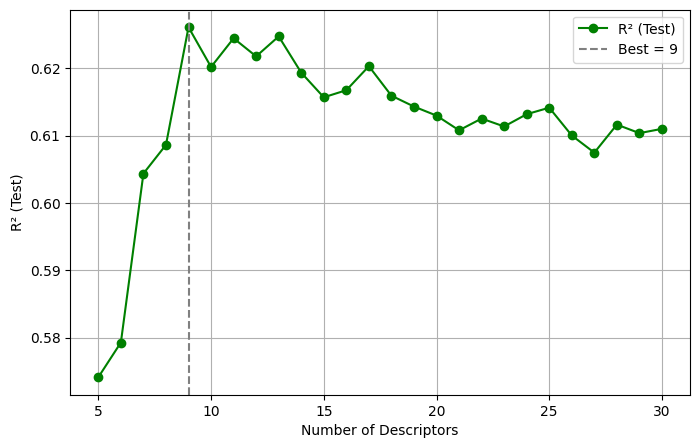

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

# === Utility functions ===
def adjusted_r2(r2, n, p):
    return 1 - ((1 - r2) * (n - 1) / (n - p - 1))

def concordance_cc(y_true, y_pred):
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    cov = np.mean((y_true - mean_true) * (y_pred - mean_pred))
    sd_true = np.std(y_true)
    sd_pred = np.std(y_pred)
    return (2 * cov) / (sd_true**2 + sd_pred**2 + (mean_true - mean_pred)**2)

def loo_q2(model, X, y):
    loo = LeaveOneOut()
    y_true, y_pred = [], []
    for train_idx, test_idx in loo.split(X):
        model.fit(X[train_idx], y.iloc[train_idx])
        y_pred.append(model.predict(X[test_idx])[0])
        y_true.append(y.iloc[test_idx].values[0])
    q2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return q2, rmse

# === SECTION 1: Feature Importance and Descriptor Count Selection ===
rf_initial = RandomForestRegressor(n_estimators=200, random_state=42)
rf_initial.fit(X_vif, y_all)
feature_importance = pd.Series(rf_initial.feature_importances_, index=X_vif.columns).sort_values(ascending=False)

metrics = []
descriptor_counts = range(5, min(30, len(feature_importance)) + 1)

for n in descriptor_counts:
    top_features = feature_importance.head(n).index.tolist()
    X_selected = X_vif[top_features]
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y_all, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    model = RandomForestRegressor(n_estimators=200, random_state=42)
    model.fit(X_train_scaled, y_train)
    y_pred_test = model.predict(X_test_scaled)

    metrics.append({
        "n_descriptors": n,
        "R2_test": r2_score(y_test, y_pred_test),
        "RMSE_test": np.sqrt(mean_squared_error(y_test, y_pred_test)),
        "MAE_test": mean_absolute_error(y_test, y_pred_test)
    })

df_metrics = pd.DataFrame(metrics)

# === SECTION 2: Optimal Descriptor Count ===
best_row = df_metrics.sort_values(by="R2_test", ascending=False).iloc[0]
best_n = int(best_row["n_descriptors"])
print(f"\n✅ Best descriptor count: {best_n} | R² = {best_row['R2_test']:.4f}, RMSE = {best_row['RMSE_test']:.4f}, MAE = {best_row['MAE_test']:.4f}")
top_features_final = feature_importance.head(best_n).index.tolist()
X_final = X_vif[top_features_final]

# === SECTION 3: Final Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X_final, y_all, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === SECTION 4: Model Training and Evaluation ===
final_model = RandomForestRegressor(n_estimators=200, random_state=42)
final_model.fit(X_train_scaled, y_train)
y_train_pred = final_model.predict(X_train_scaled)
y_test_pred = final_model.predict(X_test_scaled)

# Internal Validation
r2_train = r2_score(y_train, y_train_pred)
adj_r2_train = adjusted_r2(r2_train, len(y_train), best_n)
q2_loo, rmse_loo = loo_q2(RandomForestRegressor(n_estimators=200, random_state=42), X_train_scaled, y_train)
ccc_train = concordance_cc(y_train, y_train_pred)

# External Validation
r2_test = r2_score(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
ccc_test = concordance_cc(y_test, y_test_pred)

k_prime = LinearRegression(fit_intercept=False).fit(
    y_test_pred.reshape(-1, 1), y_test.to_numpy()
).coef_[0]
k = LinearRegression(fit_intercept=False).fit(
    y_test.to_numpy().reshape(-1, 1), y_test_pred
).coef_[0]

# Y-randomization
r2_randomized = []
n_permutations = 100
for i in range(n_permutations):
    y_random = shuffle(y_all, random_state=i)
    y_train_r, y_test_r = train_test_split(y_random, test_size=0.2, random_state=42)
    model_r = RandomForestRegressor(n_estimators=200, random_state=42)
    model_r.fit(X_train_scaled, y_train_r)
    y_pred_r = model_r.predict(X_test_scaled)
    r2_randomized.append(r2_score(y_test_r, y_pred_r))

mean_r2_random = np.mean(r2_randomized)
c_r2p = r2_test * (1 - mean_r2_random)

# === SECTION 5: Print Metrics ===
print("\n📊 Publication-Ready Validation Metrics")
print("—" * 45)
print(f"Internal Validation:")
print(f"  R²: {r2_train:.4f}")
print(f"  Adjusted R²: {adj_r2_train:.4f}")
print(f"  Q² (LOO): {q2_loo:.4f}")
print(f"  RMSE (LOO): {rmse_loo:.4f}")
print(f"  CCC (Train): {ccc_train:.4f}\n")

print(f"External Validation:")
print(f"  R² (Test): {r2_test:.4f}")
print(f"  RMSE (Test): {rmse_test:.4f}")
print(f"  CCC (Test): {ccc_test:.4f}")
print(f"  k': {k_prime:.4f}")
print(f"  k: {k:.4f}\n")

print(f"Y-Randomization:")
print(f"  Mean R² (Random): {mean_r2_random:.4f}")
print(f"  cR²p: {c_r2p:.4f}")
if c_r2p > 0.5:
    print("  ✅ Model is statistically robust (cR²p > 0.5)")
else:
    print("  ⚠️ Model may not be robust (cR²p ≤ 0.5)")

# === SECTION 6: Plot ===
plt.figure(figsize=(8, 5))
plt.plot(df_metrics["n_descriptors"], df_metrics["R2_test"], marker='o', label='R² (Test)', color='green')
plt.axvline(best_n, color='gray', linestyle='--', label=f'Best = {best_n}')
plt.xlabel("Number of Descriptors")
plt.ylabel("R² (Test)")
plt.legend()
plt.grid(True)

# Annotate best point
text_x = best_n + 1 if best_n < 25 else best_n - 5
text_y = best_r2 - 0.035
plt.text(
    text_x, text_y,
    f"R² = {best_r2:.3f}\nRMSE = {best_row['RMSE_test']:.3f}\nMAE = {best_row['MAE_test']:.3f}",
    fontsize=9,
    bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.6)
)

# Save plot
plot_dir = r"C:\\Users\\Haisoj\\Desktop\\PhD Folder\\Thesis\\DLBCL\\ML\\3\\Plots"
os.makedirs(plot_dir, exist_ok=True)
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, "Best_R2_vs_Descriptor_Count.tiff"), dpi=300)
plt.show()



✅ Best descriptor count: 9 | R² = 0.6261, RMSE = 0.7702, MAE = 0.5981


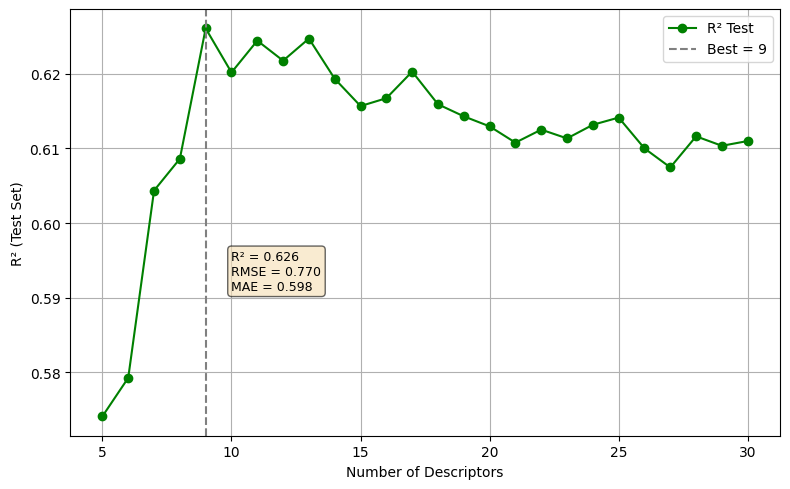

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import os

# ========== SECTION 5a: Optimal Descriptor Count Selection (Best R² Only) ==========

rf_initial = RandomForestRegressor(n_estimators=200, random_state=42)
rf_initial.fit(X_vif, y_all)
feature_importance = pd.Series(rf_initial.feature_importances_, index=X_vif.columns).sort_values(ascending=False)

metrics = []
descriptor_counts = range(5, min(30, len(feature_importance)) + 1, 1)

for n in descriptor_counts:
    top_features = feature_importance.head(n).index.tolist()
    X_selected = X_vif[top_features]
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y_all, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    model = RandomForestRegressor(n_estimators=200, random_state=42)
    model.fit(X_train_scaled, y_train)
    y_pred_test = model.predict(X_test_scaled)

    metrics.append({
        "n_descriptors": n,
        "R2_test": r2_score(y_test, y_pred_test),
        "RMSE_test": np.sqrt(mean_squared_error(y_test, y_pred_test)),
        "MAE_test": mean_absolute_error(y_test, y_pred_test)
    })

df_metrics = pd.DataFrame(metrics)

# ✅ Identify best R² (Test)
best_row = df_metrics.sort_values(by="R2_test", ascending=False).iloc[0]
best_n = int(best_row["n_descriptors"])
best_r2 = best_row["R2_test"]
print(f"\n✅ Best descriptor count: {best_n} | R² = {best_r2:.4f}, RMSE = {best_row['RMSE_test']:.4f}, MAE = {best_row['MAE_test']:.4f}")

top_features_final = feature_importance.head(best_n).index.tolist()
X_final = X_vif[top_features_final]

# ✅ Plot R² Test only with safe-positioned annotation
plt.figure(figsize=(8, 5))
plt.plot(df_metrics["n_descriptors"], df_metrics["R2_test"], label="R² Test", marker='o', color='green')
plt.axvline(best_n, color='gray', linestyle='--', label=f"Best = {best_n}")

# Minor lift to avoid touching the x-axis
text_x = best_n + 1 if best_n < 25 else best_n - 5
text_y = best_r2 - 0.035  # just a small lift from your original -0.05

annotation = (
    f"R² = {best_r2:.3f}\n"
    f"RMSE = {best_row['RMSE_test']:.3f}\n"
    f"MAE = {best_row['MAE_test']:.3f}"
)
plt.text(
    text_x,
    text_y,
    annotation,
    fontsize=9,
    bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.6)
)

plt.xlabel("Number of Descriptors")
plt.ylabel("R² (Test Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()

# 📁 Save plot
plot_dir = r"C:\\Users\\Haisoj\\Desktop\\PhD Folder\\Thesis\\DLBCL\\ML\\3\\Plots"
os.makedirs(plot_dir, exist_ok=True)
plt.savefig(os.path.join(plot_dir, "Best_R2_vs_Descriptor_Count.tiff"), dpi=300)
plt.show()


✅ Original R²: 0.6261


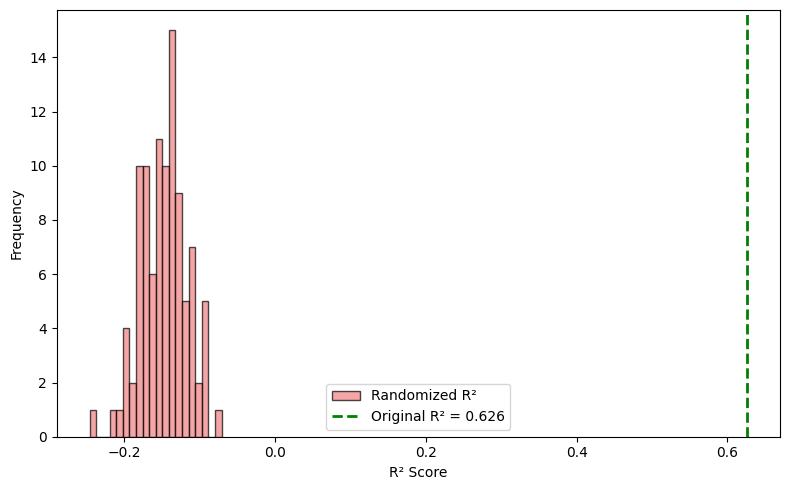


🎯 Y-randomization summary:
Number of randomized models with R² ≥ original: 0 / 100


In [15]:
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import os

# ✅ Use optimal descriptor set selected previously
X_selected = X_vif[top_features_final]  # Ensure top_features_final is defined from earlier code
y_true = y_all.copy()

# ✅ Original model performance
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_true, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

original_model = RandomForestRegressor(n_estimators=200, random_state=42)
original_model.fit(X_train_scaled, y_train)
y_pred = original_model.predict(X_test_scaled)

original_r2 = r2_score(y_test, y_pred)
print(f"✅ Original R²: {original_r2:.4f}")

# ✅ Y-Randomization
n_iterations = 100
r2_randomized = []

for i in range(n_iterations):
    y_shuffled = shuffle(y_true, random_state=i)
    X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_selected, y_shuffled, test_size=0.2, random_state=42)

    scaler_r = StandardScaler()
    X_train_r_scaled = scaler_r.fit_transform(X_train_r)
    X_test_r_scaled = scaler_r.transform(X_test_r)

    model = RandomForestRegressor(n_estimators=200, random_state=42)
    model.fit(X_train_r_scaled, y_train_r)
    y_pred_r = model.predict(X_test_r_scaled)
    r2_r = r2_score(y_test_r, y_pred_r)
    r2_randomized.append(r2_r)

# ✅ Plot distribution of randomized R²
plt.figure(figsize=(8, 5))
plt.hist(r2_randomized, bins=20, color='lightcoral', edgecolor='black', alpha=0.7, label="Randomized R²")
plt.axvline(original_r2, color='green', linestyle='--', linewidth=2, label=f"Original R² = {original_r2:.3f}")
plt.xlabel("R² Score")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()

# 📁 Save plot
plot_dir = r"C:\\Users\\Haisoj\\Desktop\\PhD Folder\\Thesis\\DLBCL\\ML\\3\\Plots"
os.makedirs(plot_dir, exist_ok=True)
plot_path_tiff = os.path.join(plot_dir, "Y_randomization.tiff")
plt.savefig(plot_path_tiff, dpi=300, format='tiff')
plt.show()

# ✅ Interpretation
count_better = sum(r >= original_r2 for r in r2_randomized)
print(f"\n🎯 Y-randomization summary:")
print(f"Number of randomized models with R² ≥ original: {count_better} / {n_iterations}")


In [17]:
from sklearn.utils import shuffle

# ✅ Final train/test split using selected descriptors
X_train, X_test, y_train, y_test = train_test_split(X_final, y_all, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ✅ Train final model on real data
final_model = RandomForestRegressor(n_estimators=200, random_state=42)
final_model.fit(X_train_scaled, y_train)
y_pred_final = final_model.predict(X_test_scaled)
r2_original = r2_score(y_test, y_pred_final)

# ✅ Y-randomization loop
r2_randomized = []
n_permutations = 100

for i in range(n_permutations):
    y_random = shuffle(y_all, random_state=i)
    y_train_r, y_test_r = train_test_split(y_random, test_size=0.2, random_state=42)
    
    model_r = RandomForestRegressor(n_estimators=200, random_state=42)
    model_r.fit(X_train_scaled, y_train_r)  # keep X the same
    y_pred_r = model_r.predict(X_test_scaled)
    
    r2_randomized.append(r2_score(y_test_r, y_pred_r))

# ✅ Compute cR²p
mean_r2_random = np.mean(r2_randomized)
c_r2p = r2_original * (1 - mean_r2_random)

print("\n🎯 Y-Randomization Summary:")
print(f"Original R² on Test Set: {r2_original:.4f}")
print(f"Mean R² from Randomized Models: {mean_r2_random:.4f}")
print(f"Y-Randomization Coefficient (cR²p): {c_r2p:.4f}")

# ✅ Interpretation
if c_r2p > 0.5:
    print("✅ Model is statistically robust (cR²p > 0.5).")
else:
    print("⚠️ Model may not be robust (cR²p ≤ 0.5). Consider descriptor refinement or more data.")



🎯 Y-Randomization Summary:
Original R² on Test Set: 0.6261
Mean R² from Randomized Models: -0.1475
Y-Randomization Coefficient (cR²p): 0.7184
✅ Model is statistically robust (cR²p > 0.5).


In [14]:
# ========== SECTION 6: VIF of Final Selected Descriptors ==========
vif_final_df = calculate_vif(X_final)
print("\n📌 VIF for Final Selected Descriptors:")
print(vif_final_df.sort_values(by="VIF", ascending=True))


📌 VIF for Final Selected Descriptors:
            Feature       VIF
3     BCUT2D_LOGPHI  0.582276
0               Ipc  1.007810
6         PEOE_VSA3  1.126038
4       VSA_EState4  1.166153
8  MaxPartialCharge  1.229345
2          SMR_VSA9  1.258557
5            AvgIpc  1.393417
1      BCUT2D_CHGLO  1.475357
7       VSA_EState8  1.527398


In [44]:
# ========== SECTION 7a: Mean Effect Calculation ==========

import numpy as np
import pandas as pd

# ---- Step 1: Basic statistics and importances ----
means  = X_final.mean()
stdevs = X_final.std()
betas  = rf_initial.feature_importances_[:len(X_final.columns)]

# ---- Step 2: Raw signed effect ----
raw_effects = (betas * means) / stdevs
raw_effects = raw_effects.replace([np.inf, -np.inf], 0).fillna(0)

# ---- Step 3: Signed normalization (sums to 1) ----
den = raw_effects.sum()
if np.isclose(den, 0.0):
    raise ValueError("Signed Mean Effect undefined: net contribution ≈ 0.")
mean_effect_signed = raw_effects / den

# ---- Step 4: Positive/Negative split ----
me_pos = mean_effect_signed.clip(lower=0)
me_neg = mean_effect_signed.clip(upper=0)

# ---- Step 5: Assemble clean DataFrame ----
mean_effect_df = pd.DataFrame({
    'Descriptor': X_final.columns,
    'Mean': means.values,
    'Std': stdevs.values,
    'Importance': betas,
    'Raw Effect': raw_effects.values,
    'Signed Effect': mean_effect_signed.values,
    '% Contribution': mean_effect_signed.values * 100,
    'Positive Part': me_pos.values,
    'Negative Part': me_neg.values
}).sort_values(by='Signed Effect', ascending=False).reset_index(drop=True)

# ---- Step 6: Round for clarity ----
mean_effect_df = mean_effect_df.round({
    'Mean': 3, 'Std': 3, 'Importance': 4,
    'Raw Effect': 4, 'Signed Effect': 4,
    '% Contribution': 2, 'Positive Part': 4, 'Negative Part': 4
})

# ---- Step 7: Print in sections for readability ----
print("\n📊 Mean Effect Summary (Signed, sum=1)\n")

print("=== Descriptor Stats ===")
print(mean_effect_df[['Descriptor','Mean','Std','Importance']].to_string(index=False))

print("\n=== Contribution Effects ===")
print(mean_effect_df[['Descriptor','Raw Effect','Signed Effect','% Contribution']].to_string(index=False))

print("\n=== Split Contributions ===")
print(mean_effect_df[['Descriptor','Positive Part','Negative Part']].to_string(index=False))

print("\nCheck Totals:")
print("Sum of signed effects =", mean_effect_signed.sum())
print("Sum of positives =", me_pos.sum(), "| Sum of negatives =", me_neg.sum())



📊 Mean Effect Summary (Signed, sum=1)

=== Descriptor Stats ===
      Descriptor          Mean          Std  Importance
   BCUT2D_LOGPHI  2.335000e+00 6.700000e-02      0.0217
          AvgIpc  3.184000e+00 2.940000e-01      0.0140
MaxPartialCharge  2.580000e-01 6.900000e-02      0.0296
     VSA_EState8  4.102000e+00 3.370000e+00      0.0455
        SMR_VSA9  1.329900e+01 7.956000e+00      0.0218
       PEOE_VSA3  1.387200e+01 7.036000e+00      0.0182
     VSA_EState4  5.462000e+00 3.843000e+00      0.0172
             Ipc  2.816583e+11 1.403019e+13      0.0200
    BCUT2D_CHGLO -2.240000e+00 1.070000e-01      0.0198

=== Contribution Effects ===
      Descriptor  Raw Effect  Signed Effect  % Contribution
   BCUT2D_LOGPHI      0.7544         0.9977           99.77
          AvgIpc      0.1521         0.2011           20.11
MaxPartialCharge      0.1111         0.1470           14.70
     VSA_EState8      0.0554         0.0732            7.32
        SMR_VSA9      0.0364         0.0481  

In [26]:
# ========== SECTION 7a: Mean Effect Calculation ==========
means = X_final.mean()
stdevs = X_final.std()
betas = rf_initial.feature_importances_[:len(X_final.columns)]
mean_effects = (betas * means) / stdevs
mean_effect_df = pd.DataFrame({
    'Descriptor': X_final.columns,
    'Mean': means.values,
    'Std': stdevs.values,
    'Importance': betas,
    'Mean Effect': mean_effects
})
print("\n📊 Mean Effect Summary:")
print(mean_effect_df.sort_values(by='Mean Effect', ascending=False))


📊 Mean Effect Summary:
                        Descriptor          Mean           Std  Importance  \
BCUT2D_LOGPHI        BCUT2D_LOGPHI  2.334845e+00  6.700340e-02    0.021650   
AvgIpc                      AvgIpc  3.184358e+00  2.939771e-01    0.014039   
MaxPartialCharge  MaxPartialCharge  2.578965e-01  6.864826e-02    0.029581   
VSA_EState8            VSA_EState8  4.101588e+00  3.369635e+00    0.045499   
SMR_VSA9                  SMR_VSA9  1.329910e+01  7.955898e+00    0.021774   
PEOE_VSA3                PEOE_VSA3  1.387177e+01  7.036432e+00    0.018242   
VSA_EState4            VSA_EState4  5.461823e+00  3.843215e+00    0.017175   
Ipc                            Ipc  2.816583e+11  1.403019e+13    0.020029   
BCUT2D_CHGLO          BCUT2D_CHGLO -2.239929e+00  1.071116e-01    0.019796   

                  Mean Effect  
BCUT2D_LOGPHI        0.754438  
AvgIpc               0.152073  
MaxPartialCharge     0.111130  
VSA_EState8          0.055382  
SMR_VSA9             0.036398  
PEO

In [22]:
# ========== SECTION 8: Train-Test Split & Model Evaluation (Before Tuning) ==========
X_train, X_test, y_train, y_test = train_test_split(X_final, y_all, test_size=0.2, random_state=42)
print(f"\n✅ Training set size: {X_train.shape}, Test set size: {X_test.shape}")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Support Vector Regression": SVR(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "KNN Regressor": KNeighborsRegressor()
}

results_train_test = []
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    results_train_test.append({
        "Model": name,
        "R² (Train)": r2_score(y_train, y_train_pred),
        "MSE (Train)": mean_squared_error(y_train, y_train_pred),
        "MAE (Train)": mean_absolute_error(y_train, y_train_pred),
        "R² (Test)": r2_score(y_test, y_test_pred),
        "MSE (Test)": mean_squared_error(y_test, y_test_pred),
        "MAE (Test)": mean_absolute_error(y_test, y_test_pred)
    })

results_train_test_df = pd.DataFrame(results_train_test).sort_values(by="R² (Test)", ascending=False)
print("\n📊 Model Performance on Train and Test Set (Before Tuning):")
print(results_train_test_df.to_string(index=False))


✅ Training set size: (2614, 9), Test set size: (654, 9)

📊 Model Performance on Train and Test Set (Before Tuning):
                    Model  R² (Train)  MSE (Train)  MAE (Train)  R² (Test)  MSE (Test)  MAE (Test)
            Random Forest    0.940659     0.087549     0.220425   0.625506    0.594045    0.600133
            KNN Regressor    0.684854     0.464953     0.516454   0.537637    0.733427    0.667498
        Gradient Boosting    0.621896     0.557838     0.584484   0.534057    0.739106    0.686373
Support Vector Regression    0.536600     0.683681     0.627557   0.422046    0.916785    0.757063
        Linear Regression    0.248511     1.108715     0.838829   0.253069    1.184826    0.891537
         Ridge Regression    0.248511     1.108715     0.838837   0.253060    1.184840    0.891551
         Lasso Regression    0.000000     1.475358     0.990503  -0.008168    1.599216    1.056157


In [24]:
# ========== SECTION 9: Cross-Validation ==========
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = []
for name, model in models.items():
    scores = cross_validate(
        model, X_train_scaled, y_train, cv=cv,
        scoring={
            'r2': make_scorer(r2_score),
            'mse': make_scorer(mean_squared_error),
            'mae': make_scorer(mean_absolute_error)
        },
        return_train_score=False
    )
    cv_results.append({
        "Model": name,
        "CV R² (Train)": np.mean(scores['test_r2']),
        "CV MSE (Train)": np.mean(scores['test_mse']),
        "CV MAE (Train)": np.mean(scores['test_mae'])
    })

df_cv = pd.DataFrame(cv_results).sort_values(by="CV R² (Train)", ascending=False)
print("\n📈 5-Fold Cross-Validation Results:")
print(df_cv.to_string(index=False))



📈 5-Fold Cross-Validation Results:
                    Model  CV R² (Train)  CV MSE (Train)  CV MAE (Train)
            Random Forest       0.590880        0.602833        0.589359
        Gradient Boosting       0.517142        0.712219        0.658604
            KNN Regressor       0.484655        0.759997        0.661803
Support Vector Regression       0.447869        0.814479        0.704935
         Lasso Regression      -0.000384        1.475583        0.990594
         Ridge Regression      -0.268489        1.877346        0.858526
        Linear Regression      -0.775679        2.632331        0.865538


In [26]:
# ========== SECTION 10: Hyperparameter Tuning ==========
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import pandas as pd

# Define models and parameter grids
param_grids = {
    "Random Forest": {
        "model": RandomForestRegressor(random_state=42),
        "params": {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
    },
    "Gradient Boosting": {
        "model": GradientBoostingRegressor(random_state=42),
        "params": {
            'n_estimators': [100, 200],
            'learning_rate': [0.05, 0.1, 0.2],
            'max_depth': [3, 5, 7]
        }
    },
    "SVR": {
        "model": SVR(),
        "params": {
            'C': [0.1, 1, 10],
            'kernel': ['rbf', 'linear'],
            'gamma': ['scale', 'auto']
        }
    },
    "KNN": {
        "model": KNeighborsRegressor(),
        "params": {
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance'],
            'p': [1, 2]
        }
    },
    "Ridge": {
        "model": Ridge(),
        "params": {
            'alpha': [0.01, 0.1, 1, 10, 100]
        }
    }
}

# Add Linear Regression (no tuning)
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)

# Run GridSearchCV for all other models
tuned_models = {}
for name, entry in param_grids.items():
    print(f"\n🔍 Tuning {name}...")
    grid = GridSearchCV(entry["model"], entry["params"], cv=5, scoring="r2", n_jobs=-1)
    grid.fit(X_train_scaled, y_train)
    tuned_models[name] = grid



🔍 Tuning Random Forest...

🔍 Tuning Gradient Boosting...

🔍 Tuning SVR...

🔍 Tuning KNN...

🔍 Tuning Ridge...


In [28]:
# ========== SECTION 11: Model Evaluation After Tuning ==========
def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    if hasattr(model, "best_estimator_"):
        estimator = model.best_estimator_
        best_params = model.best_params_
    else:
        estimator = model
        best_params = "N/A"
    
    y_train_pred = estimator.predict(X_train)
    y_test_pred = estimator.predict(X_test)
    
    return {
        "Model": name,
        "R² (Train)": r2_score(y_train, y_train_pred),
        "R² (Test)": r2_score(y_test, y_test_pred),
        "MSE (Test)": mean_squared_error(y_test, y_test_pred),
        "MAE (Test)": mean_absolute_error(y_test, y_test_pred),
        "Best Params": best_params
    }

# Evaluate all models
results = []
for name, grid in tuned_models.items():
    results.append(evaluate_model(name, grid, X_train_scaled, X_test_scaled, y_train, y_test))

# Add linear model evaluation (no tuning)
results.append(evaluate_model("Linear Regression", linear_model, X_train_scaled, X_test_scaled, y_train, y_test))

# Convert to DataFrame
eval_df = pd.DataFrame(results)
eval_df_sorted = eval_df.sort_values(by="R² (Test)", ascending=False).reset_index(drop=True)

# Display Results
print("\n📈 Model Comparison Summary (After Hyperparameter Tuning):")
print(eval_df_sorted[["Model", "R² (Train)", "R² (Test)", "MSE (Test)", "MAE (Test)", "Best Params"]].to_string(index=False))

# Extract best model name and estimator
best_model_row = eval_df_sorted.iloc[0]
best_model_name = best_model_row["Model"]
print(f"\n✅ Selected Best Model: {best_model_name}")


📈 Model Comparison Summary (After Hyperparameter Tuning):
            Model  R² (Train)  R² (Test)  MSE (Test)  MAE (Test)                                                                           Best Params
    Random Forest    0.940674   0.626474    0.592509    0.598345 {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Gradient Boosting    0.920832   0.614576    0.611383    0.603644                          {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 200}
              KNN    0.993724   0.578502    0.668604    0.623230                                     {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
              SVR    0.662542   0.490336    0.808460    0.685491                                           {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Linear Regression    0.248511   0.253069    1.184826    0.891537                                                                                   N/A
            Ridge    0.248168   0.2

In [31]:
# ========== SECTION 12: Cross-Validation After Tuning ==========
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = []
for name, model in tuned_models.items():
    scores = cross_validate(
        model, X_train_scaled, y_train, cv=cv,
        scoring={
            'r2': make_scorer(r2_score),
            'mse': make_scorer(mean_squared_error),
            'mae': make_scorer(mean_absolute_error)
        },
        return_train_score=False
    )
    cv_results.append({
        "Model": name,
        "CV R²": np.mean(scores['test_r2']),
        "CV MSE": np.mean(scores['test_mse']),
        "CV MAE": np.mean(scores['test_mae'])
    })

df_cv = pd.DataFrame(cv_results).sort_values(by="CV R²", ascending=False)
print("\n📈 5-Fold Cross-Validation Results After Tuning:")
print(df_cv.to_string(index=False))



📈 5-Fold Cross-Validation Results After Tuning:
            Model     CV R²   CV MSE   CV MAE
    Random Forest  0.589580 0.604787 0.590883
Gradient Boosting  0.576427 0.624107 0.597701
              KNN  0.562050 0.645293 0.605035
              SVR  0.480106 0.767215 0.674276
            Ridge -0.268585 1.877488 0.859482


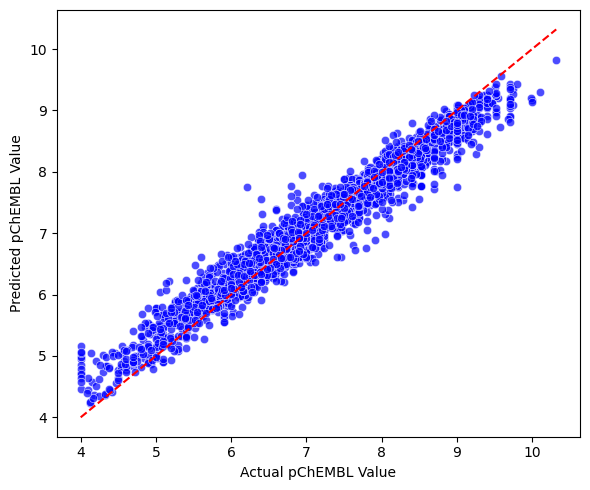

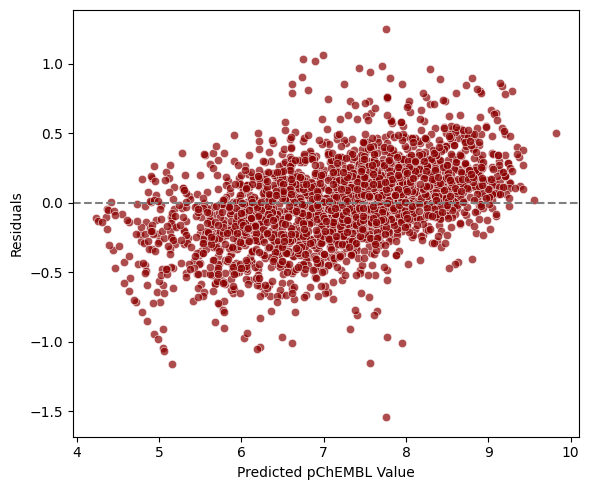

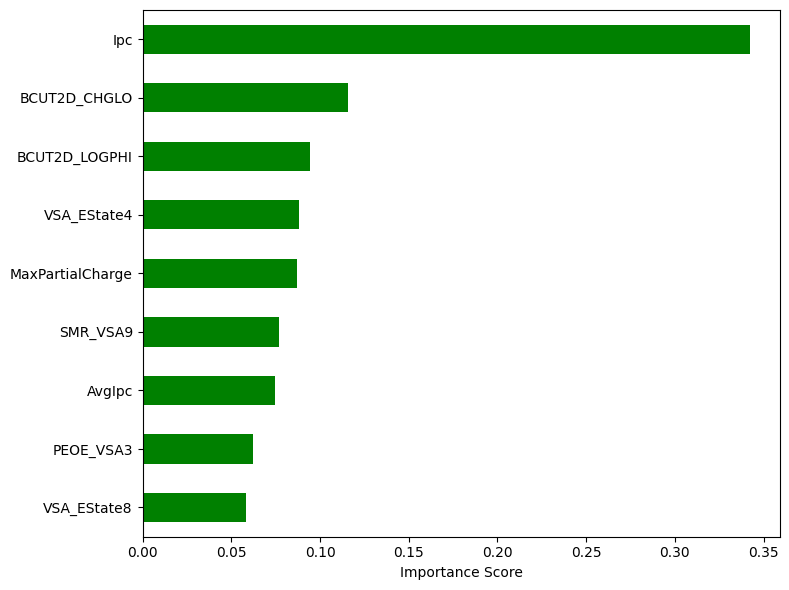

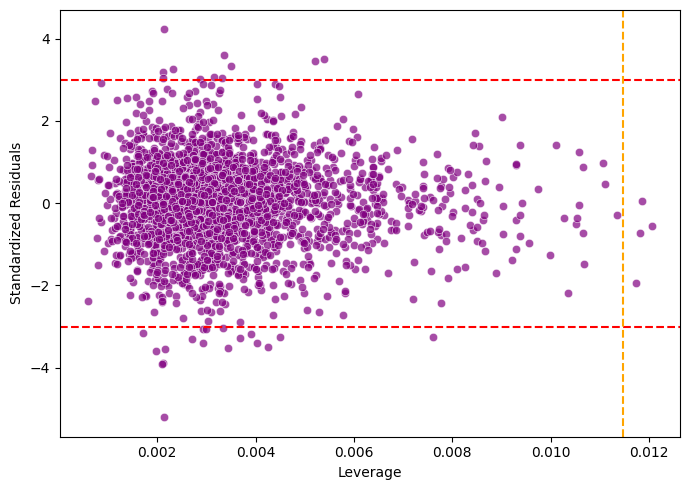

✅ All plots generated and saved as TIFF in:
C:\\Users\\Haisoj\\Desktop\\PhD Folder\\Thesis\\DLBCL\\ML\\3\\Plots


In [33]:
# ========== SECTION 13: Plots for Best Model ==========

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor

# 📁 Save directory
save_dir = r"C:\\Users\\Haisoj\\Desktop\\PhD Folder\\Thesis\\DLBCL\\ML\\3\\Plots"
os.makedirs(save_dir, exist_ok=True)

# ✅ Use hyperparameter-tuned Random Forest model
model_rf_final = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,
    min_samples_leaf=1,
    min_samples_split=2,
    random_state=42
)
model_rf_final.fit(X_train_scaled, y_train)

# 📈 Predictions and residuals
y_pred_rf = model_rf_final.predict(X_train_scaled)
residuals = y_train - y_pred_rf
standardized_residuals = (residuals - np.mean(residuals)) / np.std(residuals)

# 🎯 Leverage calculation for Williams plot
X_rf_const = sm.add_constant(X_train_scaled)
hat_matrix = X_rf_const @ np.linalg.inv(X_rf_const.T @ X_rf_const) @ X_rf_const.T
leverage = np.diag(hat_matrix)
n, p = X_train_scaled.shape
leverage_threshold = 3 * (p + 1) / n

# 🔍 Feature importance extraction
importances = model_rf_final.feature_importances_
top_features_plot = pd.Series(importances, index=top_features_final).sort_values(ascending=False)

# 🔵 Actual vs Predicted plot
plt.figure(figsize=(6, 5))
sns.scatterplot(x=y_train, y=y_pred_rf, color='blue', alpha=0.7)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
plt.xlabel("Actual pChEMBL Value")
plt.ylabel("Predicted pChEMBL Value")
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "Actual_vs_Predicted.tiff"), dpi=300)
plt.show()

# 🔴 Residual plot
plt.figure(figsize=(6, 5))
sns.scatterplot(x=y_pred_rf, y=residuals, color='darkred', alpha=0.7)
plt.axhline(0, linestyle='--', color='gray')
plt.xlabel("Predicted pChEMBL Value")
plt.ylabel("Residuals")
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "Residuals.tiff"), dpi=300)
plt.show()

# 🟢 Feature importance bar plot
plt.figure(figsize=(8, 6))
top_features_plot.sort_values().plot(kind='barh', color='green')
plt.xlabel("Importance Score")
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "Feature_Importance.tiff"), dpi=300)
plt.show()

# 🟣 Williams plot (Filtered version)
max_lev = np.percentile(leverage, 99.5)
mask = leverage < max_lev

plt.figure(figsize=(7, 5))
sns.scatterplot(x=leverage[mask], y=standardized_residuals[mask], color='purple', alpha=0.7)
plt.axhline(3, linestyle='--', color='red')
plt.axhline(-3, linestyle='--', color='red')
plt.axvline(leverage_threshold, linestyle='--', color='orange')
plt.xlabel("Leverage")
plt.ylabel("Standardized Residuals")
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "Williams_Plot_Filtered.tiff"), dpi=300)
plt.show()

print("✅ All plots generated and saved as TIFF in:")
print(save_dir)


In [30]:
# ========== SECTION 14: Save Best Model Predictions and Top Compounds ==========

import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm

# ✅ Step 1: Reset index to ensure alignment
X_top20 = X_final.copy().reset_index(drop=True)
y_final = y_all.reset_index(drop=True)
df_full_reset = df_full.reset_index(drop=True)

# ✅ Step 2: Extract identifiers
ids = df_full_reset.loc[X_top20.index, 'Molecule ChEMBL ID']
smiles = df_full_reset.loc[X_top20.index, 'Smiles']

# ✅ Step 3: Scale the features
scaler_final = StandardScaler()
X_scaled_final = scaler_final.fit_transform(X_top20)

# ✅ Step 4: Train Best Model — Tuned Random Forest
model_best = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,
    min_samples_leaf=1,
    min_samples_split=2,
    random_state=42
)
model_best.fit(X_scaled_final, y_final)

# ✅ Step 5: Predict and calculate residuals
y_pred_best = model_best.predict(X_scaled_final)
residuals_best = y_final - y_pred_best

# ✅ Step 6: Leverage calculation
X_const_final = sm.add_constant(X_scaled_final)
hat_matrix_best = X_const_final @ np.linalg.inv(X_const_final.T @ X_const_final) @ X_const_final.T
leverage_best = np.diag(hat_matrix_best)

# ✅ Step 7: Combine results into DataFrame
results_df = pd.DataFrame({
    'Molecule ChEMBL ID': ids.values,
    'Smiles': smiles.values,
    'Actual pChEMBL': y_final.values,
    'Predicted pChEMBL': y_pred_best,
    'Residuals': residuals_best,
    'Leverage': leverage_best
})

# Add descriptor values
for feature in X_top20.columns:
    results_df[feature] = X_top20[feature].values

# ✅ Step 8: Apply Applicability Domain filter
h_star = 3 * (X_top20.shape[1] + 1) / X_top20.shape[0]
within_domain_df = results_df[results_df['Leverage'] <= h_star].copy()

# ✅ Step 9: Extract top 20 predicted compounds
top20_compounds = within_domain_df.sort_values(by='Predicted pChEMBL', ascending=False).head(20).reset_index(drop=True)

# ✅ Output preview
print("\n📊 Full Dataset with Predictions and Descriptors:")
print(results_df.head())

print("\n💎 Top 20 Predicted Compounds Within Applicability Domain:")
print(top20_compounds[['Molecule ChEMBL ID', 'Smiles', 'Predicted pChEMBL']])

# ✅ Step 10: Save results
save_path = r"C:\\Users\\Haisoj\\Desktop\\PhD Folder\\Thesis\\DLBCL\\ML\\3"
os.makedirs(save_path, exist_ok=True)

results_df.to_csv(os.path.join(save_path, "Full_Prediction_Results_BestModel.csv"), index=False)
top20_compounds.to_csv(os.path.join(save_path, "Top20_BestModel_Predicted_Compounds.csv"), index=False)

print("\n✅ Saved to:")
print("- Full_Prediction_Results_BestModel.csv")
print("- Top20_BestModel_Predicted_Compounds.csv")



📊 Full Dataset with Predictions and Descriptors:
  Molecule ChEMBL ID                                             Smiles  \
0      CHEMBL4441003  Cc1cccc2nc([C@H](C)Nc3ncnc4[nH]cc(-c5cccc(NS(C...   
1      CHEMBL3704739  Cc1nc(-c2cn3c(n2)-c2ccc(-c4cnn(C)c4N4CCN(C)[C@...   
2      CHEMBL4434674  COc1ncc(-c2cc(-c3ncc(CN4C[C@@H](C)O[C@@H](C)C4...   
3      CHEMBL3403664  C[C@H](Nc1ncnc(N)c1C#N)c1nc2ccc(F)cc2c(S(C)(=O...   
4      CHEMBL4541570   CC(Nc1ncnc2[nH]cnc12)c1cc2ccccn2c(=O)c1-c1ccccc1   

   Actual pChEMBL  Predicted pChEMBL  Residuals  Leverage           Ipc  \
0           10.40           9.634655   0.765345  0.001022  2.149163e+09   
1           10.32           9.839230   0.480770  0.006364  8.532375e+08   
2           10.10           9.285096   0.814904  0.002143  1.462703e+08   
3           10.00           9.252765   0.747235  0.003671  2.143907e+07   
4           10.00           9.083160   0.916840  0.000676  9.342845e+06   

   BCUT2D_CHGLO   SMR_VSA9  BCUT2D_LOGPHI  VSA_E

⚠️ Leverage threshold (h*): 0.0115
🧪 Total compounds within applicability domain: 3262
🔥 Top 10% high-activity compounds within domain: 326
💊 Drug-like compounds after activity + domain filter: 105


[16:32:50] DEPRECATION WARNING: please use MorganGenerator
[16:32:50] DEPRECATION WARNING: please use MorganGenerator
[16:32:50] DEPRECATION WARNING: please use MorganGenerator
[16:32:50] DEPRECATION WARNING: please use MorganGenerator
[16:32:50] DEPRECATION WARNING: please use MorganGenerator
[16:32:50] DEPRECATION WARNING: please use MorganGenerator
[16:32:50] DEPRECATION WARNING: please use MorganGenerator
[16:32:50] DEPRECATION WARNING: please use MorganGenerator
[16:32:50] DEPRECATION WARNING: please use MorganGenerator
[16:32:50] DEPRECATION WARNING: please use MorganGenerator
[16:32:50] DEPRECATION WARNING: please use MorganGenerator
[16:32:50] DEPRECATION WARNING: please use MorganGenerator
[16:32:50] DEPRECATION WARNING: please use MorganGenerator
[16:32:50] DEPRECATION WARNING: please use MorganGenerator
[16:32:50] DEPRECATION WARNING: please use MorganGenerator
[16:32:50] DEPRECATION WARNING: please use MorganGenerator
[16:32:50] DEPRECATION WARNING: please use MorganGenerat

🧬 Selected 10 diverse cluster representatives for docking.


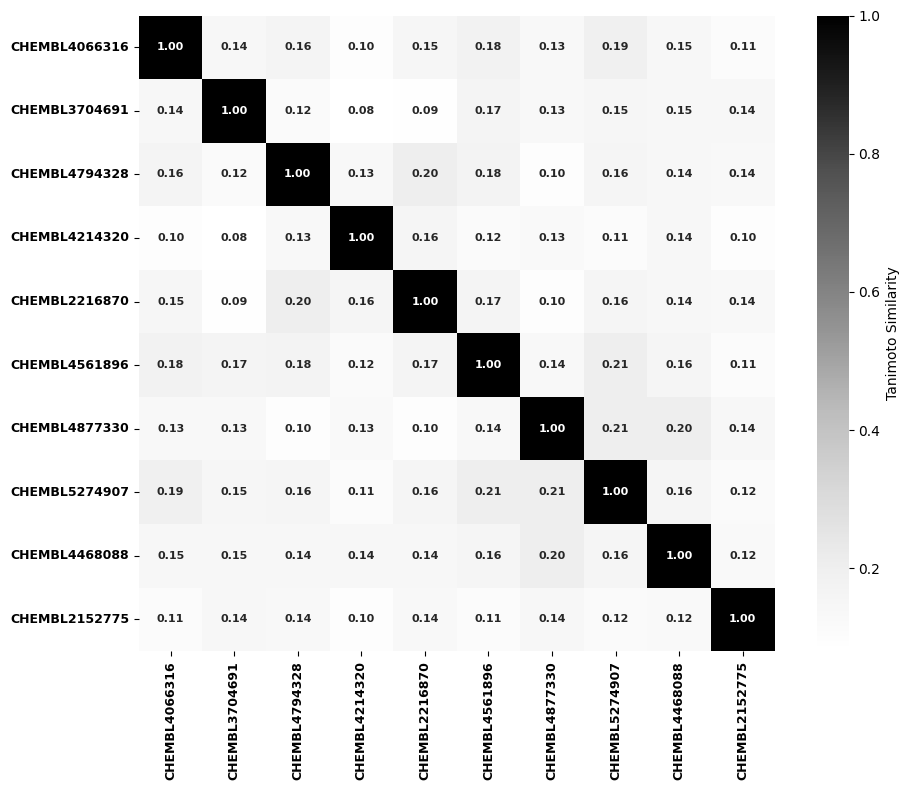


✅ Docking list and heatmap saved to:
C:\\Users\\Haisoj\\Desktop\\PhD Folder\\Thesis\\DLBCL\\ML\\3


In [36]:
# ========== SECTION 15: Activity + Drug-Likeness + Clustering Pipeline (Automated RDKit Descriptors Only) ==========

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors, Crippen
from rdkit.ML.Cluster import Butina
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os

# ✅ Step 1: Combine prediction, residual, leverage into master DataFrame
df_preds = df_full.copy()
df_preds['Predicted pChEMBL'] = y_pred_best
df_preds['Residuals'] = residuals_best
df_preds['Leverage'] = leverage_best

# ✅ Step 2: Compute leverage threshold
h_star = 3 * (X_train_scaled.shape[1] + 1) / X_train_scaled.shape[0]
print(f"⚠️ Leverage threshold (h*): {h_star:.4f}")

# ✅ Step 3: Filter by applicability domain
df_in_domain = df_preds[df_preds['Leverage'] <= h_star].copy()
print(f"🧪 Total compounds within applicability domain: {df_in_domain.shape[0]}")

# ✅ Step 4: Apply high-activity filter (top 10% within domain)
top_n = int(0.10 * df_in_domain.shape[0])
df_top_active = df_in_domain.sort_values("Predicted pChEMBL", ascending=False).head(top_n)
print(f"🔥 Top 10% high-activity compounds within domain: {df_top_active.shape[0]}")

# ✅ Step 5: Drug-likeness filtering (Lipinski + Veber)
def is_drug_like(mol):
    if mol is None:
        return False
    mw = Descriptors.MolWt(mol)
    logp = Crippen.MolLogP(mol)
    tpsa = Descriptors.TPSA(mol)
    hbd = Descriptors.NumHDonors(mol)
    hba = Descriptors.NumHAcceptors(mol)
    rotb = Descriptors.NumRotatableBonds(mol)
    return (mw <= 500 and logp <= 5 and hbd <= 5 and hba <= 10 and tpsa <= 140 and rotb <= 10)

df_top_active['Mol'] = df_top_active['Smiles'].apply(Chem.MolFromSmiles)
df_druglike = df_top_active[df_top_active['Mol'].apply(is_drug_like)].copy()
print(f"💊 Drug-like compounds after activity + domain filter: {df_druglike.shape[0]}")

# ✅ Step 6: Compute only model-specific descriptors using RDKit
rdkit_funcs = {name: func for name, func in Descriptors.__dict__.items() if callable(func)}
descriptor_funcs = {name: rdkit_funcs[name] for name in top_features_final if name in rdkit_funcs}

for name, func in descriptor_funcs.items():
    df_druglike[name] = df_druglike['Mol'].apply(func)

# ✅ Step 6.5: Select relevant columns for final docking DataFrame
df_druglike_final = df_druglike[
    ['Smiles', 'Molecule ChEMBL ID', 'pChEMBL Value', 'Predicted pChEMBL', 'Residuals', 'Leverage', 'Mol'] +
    list(descriptor_funcs.keys())
]

# ✅ Step 7: Compute ECFP4 fingerprints
mols = df_druglike_final['Mol'].tolist()
fps = [AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024) for m in mols]

# ✅ Step 8: Compute Tanimoto distance matrix
dists = []
n_fps = len(fps)
for i in range(1, n_fps):
    sims = DataStructs.BulkTanimotoSimilarity(fps[i], fps[:i])
    dists.extend([1 - x for x in sims])

# ✅ Step 9: Cluster using Butina algorithm (cutoff = 0.7)
clusters = Butina.ClusterData(dists, n_fps, 0.7, isDistData=True)
rep_indices = [cluster[0] for cluster in clusters]

# ✅ Step 10: Extract representative compounds
df_docking = df_druglike_final.iloc[rep_indices].copy()
print(f"🧬 Selected {len(df_docking)} diverse cluster representatives for docking.")

# ✅ Step 11: Generate Tanimoto similarity matrix
rep_fps = [AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024) for m in df_docking['Mol']]
sim_matrix = np.zeros((len(rep_fps), len(rep_fps)))
for i in range(len(rep_fps)):
    for j in range(len(rep_fps)):
        sim_matrix[i, j] = DataStructs.TanimotoSimilarity(rep_fps[i], rep_fps[j])

# ✅ Step 12: Plot similarity heatmap with bold text and axis
ids = df_docking['Molecule ChEMBL ID'].tolist()
plt.figure(figsize=(10, 8))
sns.heatmap(
    sim_matrix,
    cmap='Greys',
    xticklabels=ids,
    yticklabels=ids,
    square=True,
    annot=True,
    fmt=".2f",
    annot_kws={"size": 8, "weight": "bold"},
    cbar_kws={'label': 'Tanimoto Similarity'}
)
plt.xticks(rotation=90, fontsize=9, fontweight='bold')
plt.yticks(rotation=0, fontsize=9, fontweight='bold')
plt.tight_layout()

# ✅ Step 13: Save heatmap and docking set
save_path = r"C:\\Users\\Haisoj\\Desktop\\PhD Folder\\Thesis\\DLBCL\\ML\\3"
os.makedirs(save_path, exist_ok=True)

plt.savefig(os.path.join(save_path, "Tanimoto_Docking_Heatmap.tiff"), dpi=300)
plt.show()

df_docking.drop(columns=["Mol"], inplace=True)
df_docking.to_csv(os.path.join(save_path, "Docking_Compounds_Selected_Descriptors.csv"), index=False)
print(f"\n✅ Docking list and heatmap saved to:\n{save_path}")


In [42]:
import os
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

# === Load new design SMILES ===
df_new = pd.read_csv(r"C:\Users\Haisoj\Desktop\PhD Folder\Thesis\DLBCL\ML\3\Design\Optimization\Final USED Design Smiles.csv")
df_new['Mol'] = df_new['SMILE'].apply(Chem.MolFromSmiles)
df_new = df_new[df_new['Mol'].notnull()].copy()

# === Compute all RDKit descriptors ===
all_desc = [desc[0] for desc in Descriptors._descList]
calc = MoleculeDescriptors.MolecularDescriptorCalculator(all_desc)
desc_values = [calc.CalcDescriptors(mol) for mol in df_new['Mol']]
desc_df = pd.DataFrame(desc_values, columns=all_desc)

# === Merge descriptors with original DataFrame ===
desc_df = pd.concat([df_new.reset_index(drop=True), desc_df], axis=1)

# === Filter to model descriptors only ===
desc_df = desc_df.dropna(subset=top_features_final)
X_new = desc_df[top_features_final].copy()

# === Scale new compounds using training scaler ===
X_new_scaled = scaler_final.transform(X_new)

# === Predict activity using trained model ===
y_pred_new = model_best.predict(X_new_scaled)

# === Compute leverage using training hat matrix ===
def add_constant_column(X):
    return np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)

X_train_const = add_constant_column(X_train_scaled)
X_new_const = add_constant_column(X_new_scaled)
XTX_inv = np.linalg.inv(X_train_const.T @ X_train_const)

# Leverage: hᵢ = xᵢᵀ (XᵀX)^(-1) xᵢ
leverages_new = np.einsum('ij,jk,ik->i', X_new_const, XTX_inv, X_new_const)

# === Calculate leverage threshold h* ===
h_star = 3 * (X_train_scaled.shape[1] + 1) / X_train_scaled.shape[0]
print(f"📏 Leverage threshold (h*): {h_star:.4f}")

# === Combine results ===
df_results = pd.DataFrame({
    'SMILE': desc_df['SMILE'],
    'Predicted pChEMBL': y_pred_new,
    'Leverage': leverages_new,
    'In Applicability Domain': leverages_new <= h_star
})

# Add descriptor values used by the model
for feature in top_features_final:
    df_results[feature] = X_new[feature].values

# === Save predictions ===
save_path = r"C:\Users\Haisoj\Desktop\PhD Folder\Thesis\DLBCL\ML\3\Design\Optimization"
os.makedirs(save_path, exist_ok=True)

df_results.to_csv(os.path.join(save_path, "New_Design_Prediction_Leverage.csv"), index=False)

print("✅ Done. Saved to New_Design_Prediction_Leverage.csv")
print(df_results.head())


📏 Leverage threshold (h*): 0.0115
✅ Done. Saved to New_Design_Prediction_Leverage.csv
                                               SMILE  Predicted pChEMBL  \
0  CCC(=O)N1CC[C@@H](C1)OC1=NC=NC2=CC=C(C=C12)C1=...           8.121003   
1  COC1=CC=C(C=N1)C1=CC2=C(N[C@H]3CCN(C3)C(=O)C3C...           8.292332   
2  CC1=C(C(=O)N2CC[C@H]3CN([C@H]3C2)C2=CC=NC(=N2)...           7.880929   

   Leverage  In Applicability Domain           Ipc  BCUT2D_CHGLO   SMR_VSA9  \
0  0.003262                     True  1.042281e+07     -2.165764  28.956101   
1  0.001798                     True  4.216758e+07     -2.261030  17.006891   
2  0.006095                     True  1.102670e+08     -2.535620  22.645235   

   BCUT2D_LOGPHI  VSA_EState4    AvgIpc  PEOE_VSA3  VSA_EState8  \
0       2.303803     2.764245  3.262114  14.951936     3.118626   
1       2.286776     2.908061  3.324819  14.951936     2.846444   
2       2.369881     3.054116  3.266933   9.967957     4.165997   

   MaxPartialCharge  
0    